In [1]:
from load_dataset import load_admission_dataset
from model_manager import PytorchModelManager
from cf_engine.engine import CFEnginePytorch
from cf_engine.counterfactual import CounterfactualExampleBySubset

In [2]:
import numpy as mp
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

In [3]:
dataset = load_admission_dataset()
mm = PytorchModelManager(dataset)
dm = mm.get_dir_manager()
try:
    mm.load_model()
except FileNotFoundError:
    mm.train()
    mm.save_model()
engine = CFEnginePytorch(mm, dataset)

/Users/chengfurui/Projects/counterfactuals/env/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0, loss=0.538, train_accuracy=0.792, test_accuracy=0.790
Epoch: 1, loss=0.657, train_accuracy=0.790, test_accuracy=0.810
Epoch: 2, loss=0.382, train_accuracy=0.800, test_accuracy=0.810
Epoch: 3, loss=0.523, train_accuracy=0.810, test_accuracy=0.810
Epoch: 4, loss=0.260, train_accuracy=0.797, test_accuracy=0.820
Epoch: 5, loss=0.292, train_accuracy=0.812, test_accuracy=0.800
Epoch: 6, loss=0.512, train_accuracy=0.812, test_accuracy=0.830
Epoch: 7, loss=0.270, train_accuracy=0.818, test_accuracy=0.800
Epoch: 8, loss=0.289, train_accuracy=0.825, test_accuracy=0.810
Epoch: 9, loss=0.267, train_accuracy=0.830, test_accuracy=0.820
Epoch: 10, loss=0.383, train_accuracy=0.848, test_accuracy=0.840
Epoch: 11, loss=0.245, train_accuracy=0.830, test_accuracy=0.800
Epoch: 12, loss=0.210, train_accuracy=0.840, test_accuracy=0.810
Epoch: 13, loss=0.256, train_accuracy=0.853, test_accuracy=0.810
Epoch: 14, loss=0.504, train_accuracy=0.858, test_accuracy=0.820
Epoch: 15, loss=0.272, train_accura

In [9]:
target_name = dataset.get_target_names(False)
pre_target_name = '{}_pred'.format(target_name)
desc = dataset.get_description()
neg = False
pos = True
def plot_subset_cf(subset_attr_cf):
    for i, (feature, subset_cf) in enumerate(subset_attr_cf.items()):
        cf_df = subset_cf.get_cf().reset_index(drop=True)
        original_df = subset_cf.get_instance().reset_index(drop=True)
#         valid_index = cf_df[pre_target_name] != \
#             original_df.loc[cf_df['OriginIndex'], pre_target_name]
#         valid_cf = cf_df.loc[valid_index, :]
#         valid_instance = original_df.loc[valid_cf['OriginIndex'], :]
        valid_index = cf_df[pre_target_name] != original_df[pre_target_name]
        valid_cf = cf_df[valid_index]
        valid_instance = original_df[valid_index]
        pos_valid_cf_attr_value = valid_cf[valid_cf[pre_target_name] == pos][feature]
        neg_valid_cf_attr_value = valid_cf[valid_cf[pre_target_name] == neg][feature]
        pos_valid_instance_attr_value = valid_instance[valid_instance[pre_target_name] == pos][feature]
        neg_valid_instance_attr_value = valid_instance[valid_instance[pre_target_name] == neg][feature]
        # add subplots
        bins = 25
        plt.subplot(len(subset_attr_cf), 2, i*2+1)
        if desc[feature]['type'] == 'numerical':
            plt.hist(neg_valid_instance_attr_value, bins=bins, alpha=0.5, label='neg', color='b')
            plt.hist(pos_valid_cf_attr_value, bins=bins, alpha=0.5, label='pos', color='r')
        else:
            names = desc[feature]['category']
            neg_value = [(neg_valid_instance_attr_value == cat).sum() for cat in names]
            pos_value = [(pos_valid_cf_attr_value == cat).sum() for cat in names]
            names = [str(cat) for cat in names]
            plt.bar(names, neg_value, alpha=0.5, label='neg', color='b')
            plt.bar(names, pos_value, alpha=0.5, label='pos', color='r')
        
        plt.legend(loc='upper right')
        plt.title('{}: neg->pos'.format(feature))
        plt.subplot(len(subset_attr_cf), 2, i*2+2)
        if desc[feature]['type'] == 'numerical':
            plt.hist(pos_valid_instance_attr_value, bins=bins, alpha=0.5, label='pos', color='r')
            plt.hist(neg_valid_cf_attr_value, bins=bins, alpha=0.5, label='neg', color='b')
        else:
            names = desc[feature]['category']
            neg_value = [(neg_valid_cf_attr_value == cat).sum() for cat in names]
            pos_value = [(pos_valid_instance_attr_value == cat).sum() for cat in names]
            names = [str(cat) for cat in names]
            plt.bar(names, pos_value, alpha=0.5, label='pos', color='r')
            plt.bar(names, neg_value, alpha=0.5, label='neg', color='b')
        plt.legend(loc='upper right')
        plt.title('{}: pos->neg'.format(feature))
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

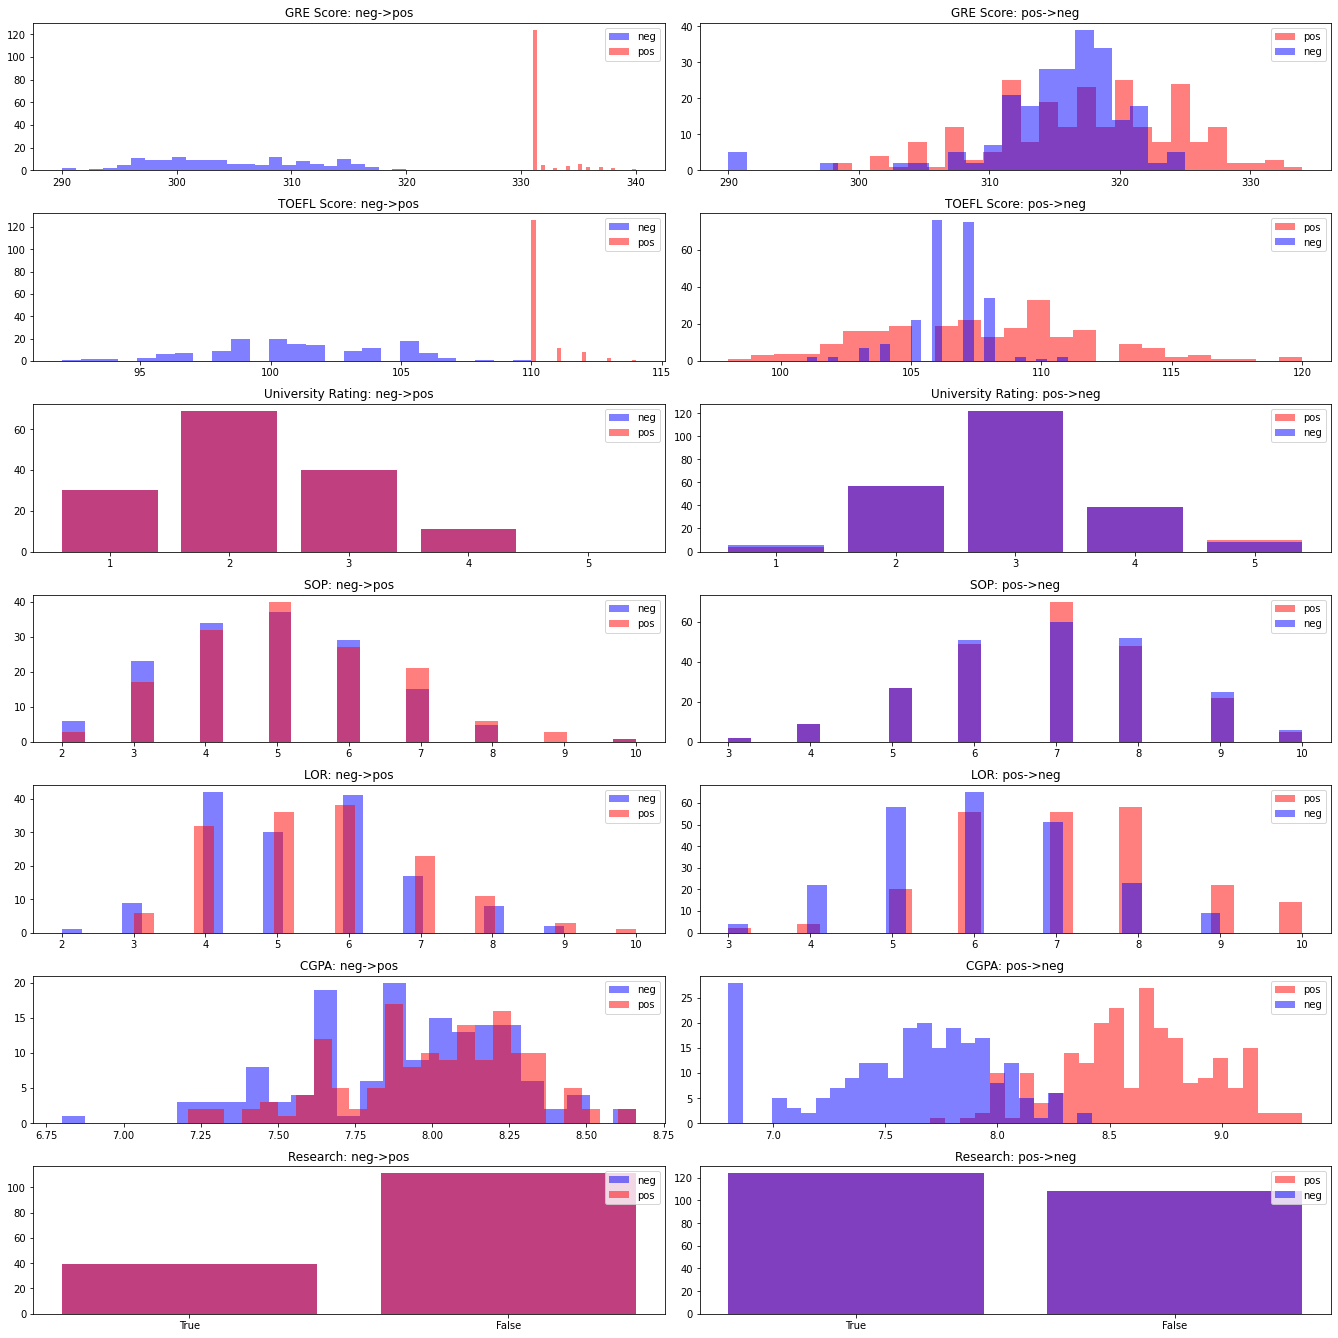

In [10]:
subset = {}
subset_attr_cf = engine.generate_cfs_subset(subset, batch_size=1024)
fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
plot_subset_cf(subset_attr_cf)

/Users/chengfurui/Projects/counterfactuals/env/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[184/184]  Epoch-0, time cost: 3.960s, loss: 35.315, iteration: 2000, validation rate: 0.652
Total time cost: 4.028, validation rate: 0.652, average distance: 0.854, average loss: 35.315
[184/184]  Epoch-0, time cost: 3.973s, loss: 37.808, iteration: 2000, validation rate: 0.625
Total time cost: 4.038, validation rate: 0.625, average distance: 0.811, average loss: 37.808


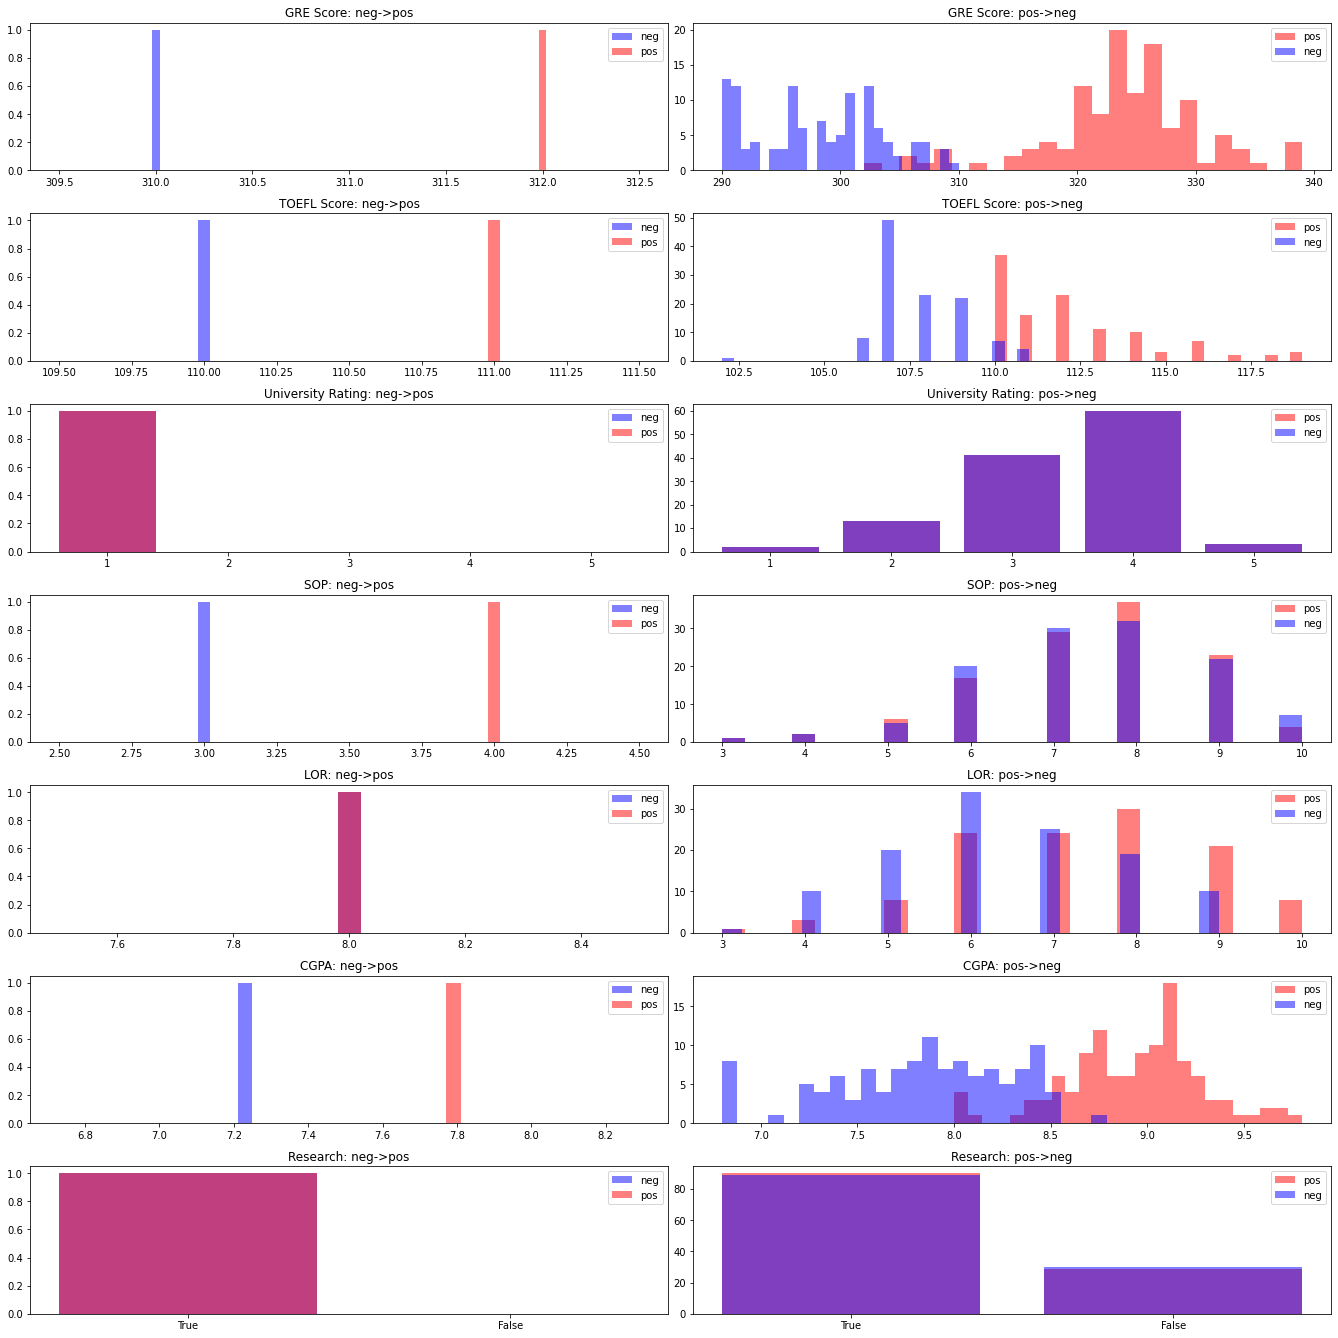

In [12]:
subset = {'TOEFL Score': {'min': 110, 'max': 120}}
subset_attr_cf = engine.generate_cfs_subset(subset, batch_size=1024)
fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
plot_subset_cf(subset_attr_cf)